# Dataset Friuli-Venezia Giulia
Registrazione delle misure combinate di ISAC e SCIA. Si è visto che le differenze tra serie provenienti dalla stessa stazione (SCIA - ISAC) hanno un leggero bias positivo sia in T_MIN che in T_MAX.

La procedura si articola nei seguenti passaggi:
1. [caricamento dei dati grezzi](#caricamento-da-frammenti) e uniformazione negli schemi esposti sotto;
1. [primo quality check](#quality-check): controllo errori di consistenza nella singola serie e nelle coppie di serie della stessa stazione;
1. [overview disponibilità dati](#overview-disponibilità-dati): plot che mostrano la disponibilità temporale e spaziale di serie;
1. [merging](#merging) di ISAC e SCIA, poi aggiunta di ARPA.

## Data model
### Metadati
| station_id | station_name | network | state | lon    | lat    | elevation | dataset_id | original_id |
|------------|--------------|---------|-------|--------|--------|-----------|------------|-------------|
| utf8()     | utf8()       | utf8()  | utf8()|double()|double()| double()  | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs   | obs    | obs    | obs       | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "extra" collegata tramite "station_id".

### Dati
|series_id|date|value|merged|variable|
|---------|----|-----|------|--------|
|utf8()|date()|double()|bool()|utf8()|
| fkey    |obs | obs | obs  | obs    |

Note:
- `merged` indica se il valore in riga è il risultato di un merge.


In [42]:
dataset_id <- "ARPAFVG"
state <- "Friuli-Venezia Giulia"


In [43]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(stringr, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source(str_glue("notebooks/integrazioni_regionali/FVG/procedures/load_daily.R"))
source(str_glue("notebooks/integrazioni_regionali/FVG/procedures/match_taggers.R"))
source("notebooks/integrazioni_regionali/procedure/common_steps.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
source("notebooks/integrazioni_regionali/procedure/tools.R")
source("src/database/tools.R")
source("src/load/ITA.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")
state_boundaries <- load.italian_boundaries("state") |> filter(shapeName == "Friuli Venezia Giulia")


## Caricamento da frammenti
Dati giornalieri come forniti dall'ente, in formato tabella Arrow


In [11]:
daily_dataset <- load_daily_data.arpafvg() |> prepare_daily_data(first_date, last_date)
checkpoint_database(daily_dataset$database, dataset_id, "raw")
write_extra_metadata(daily_dataset$extra_meta, dataset_id, provisional = FALSE)
rm(daily_dataset)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2106923,112.6,3912102,209.0,NA,3912102,209
Vcells,3663630,28.0,16908558,129.1,16384,16906781,129


## Quality check
Controllo gross errors, dati ripetuti, T_MIN >= T_MAX, serie intere

In [12]:
raw_database <- open_checkpoint(dataset_id, "raw")
qc_database <- qc1(raw_database, stop_on_error = TRUE)

checkpoint_database(qc_database, dataset_id, "qc1")
rm(raw_database)
rm(qc_database)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2200296,117.6,3912102,209.0,NA,3912102,209.0
Vcells,4486471,34.3,20370269,155.5,16384,20344744,155.3


## Overview disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese e sul territorio

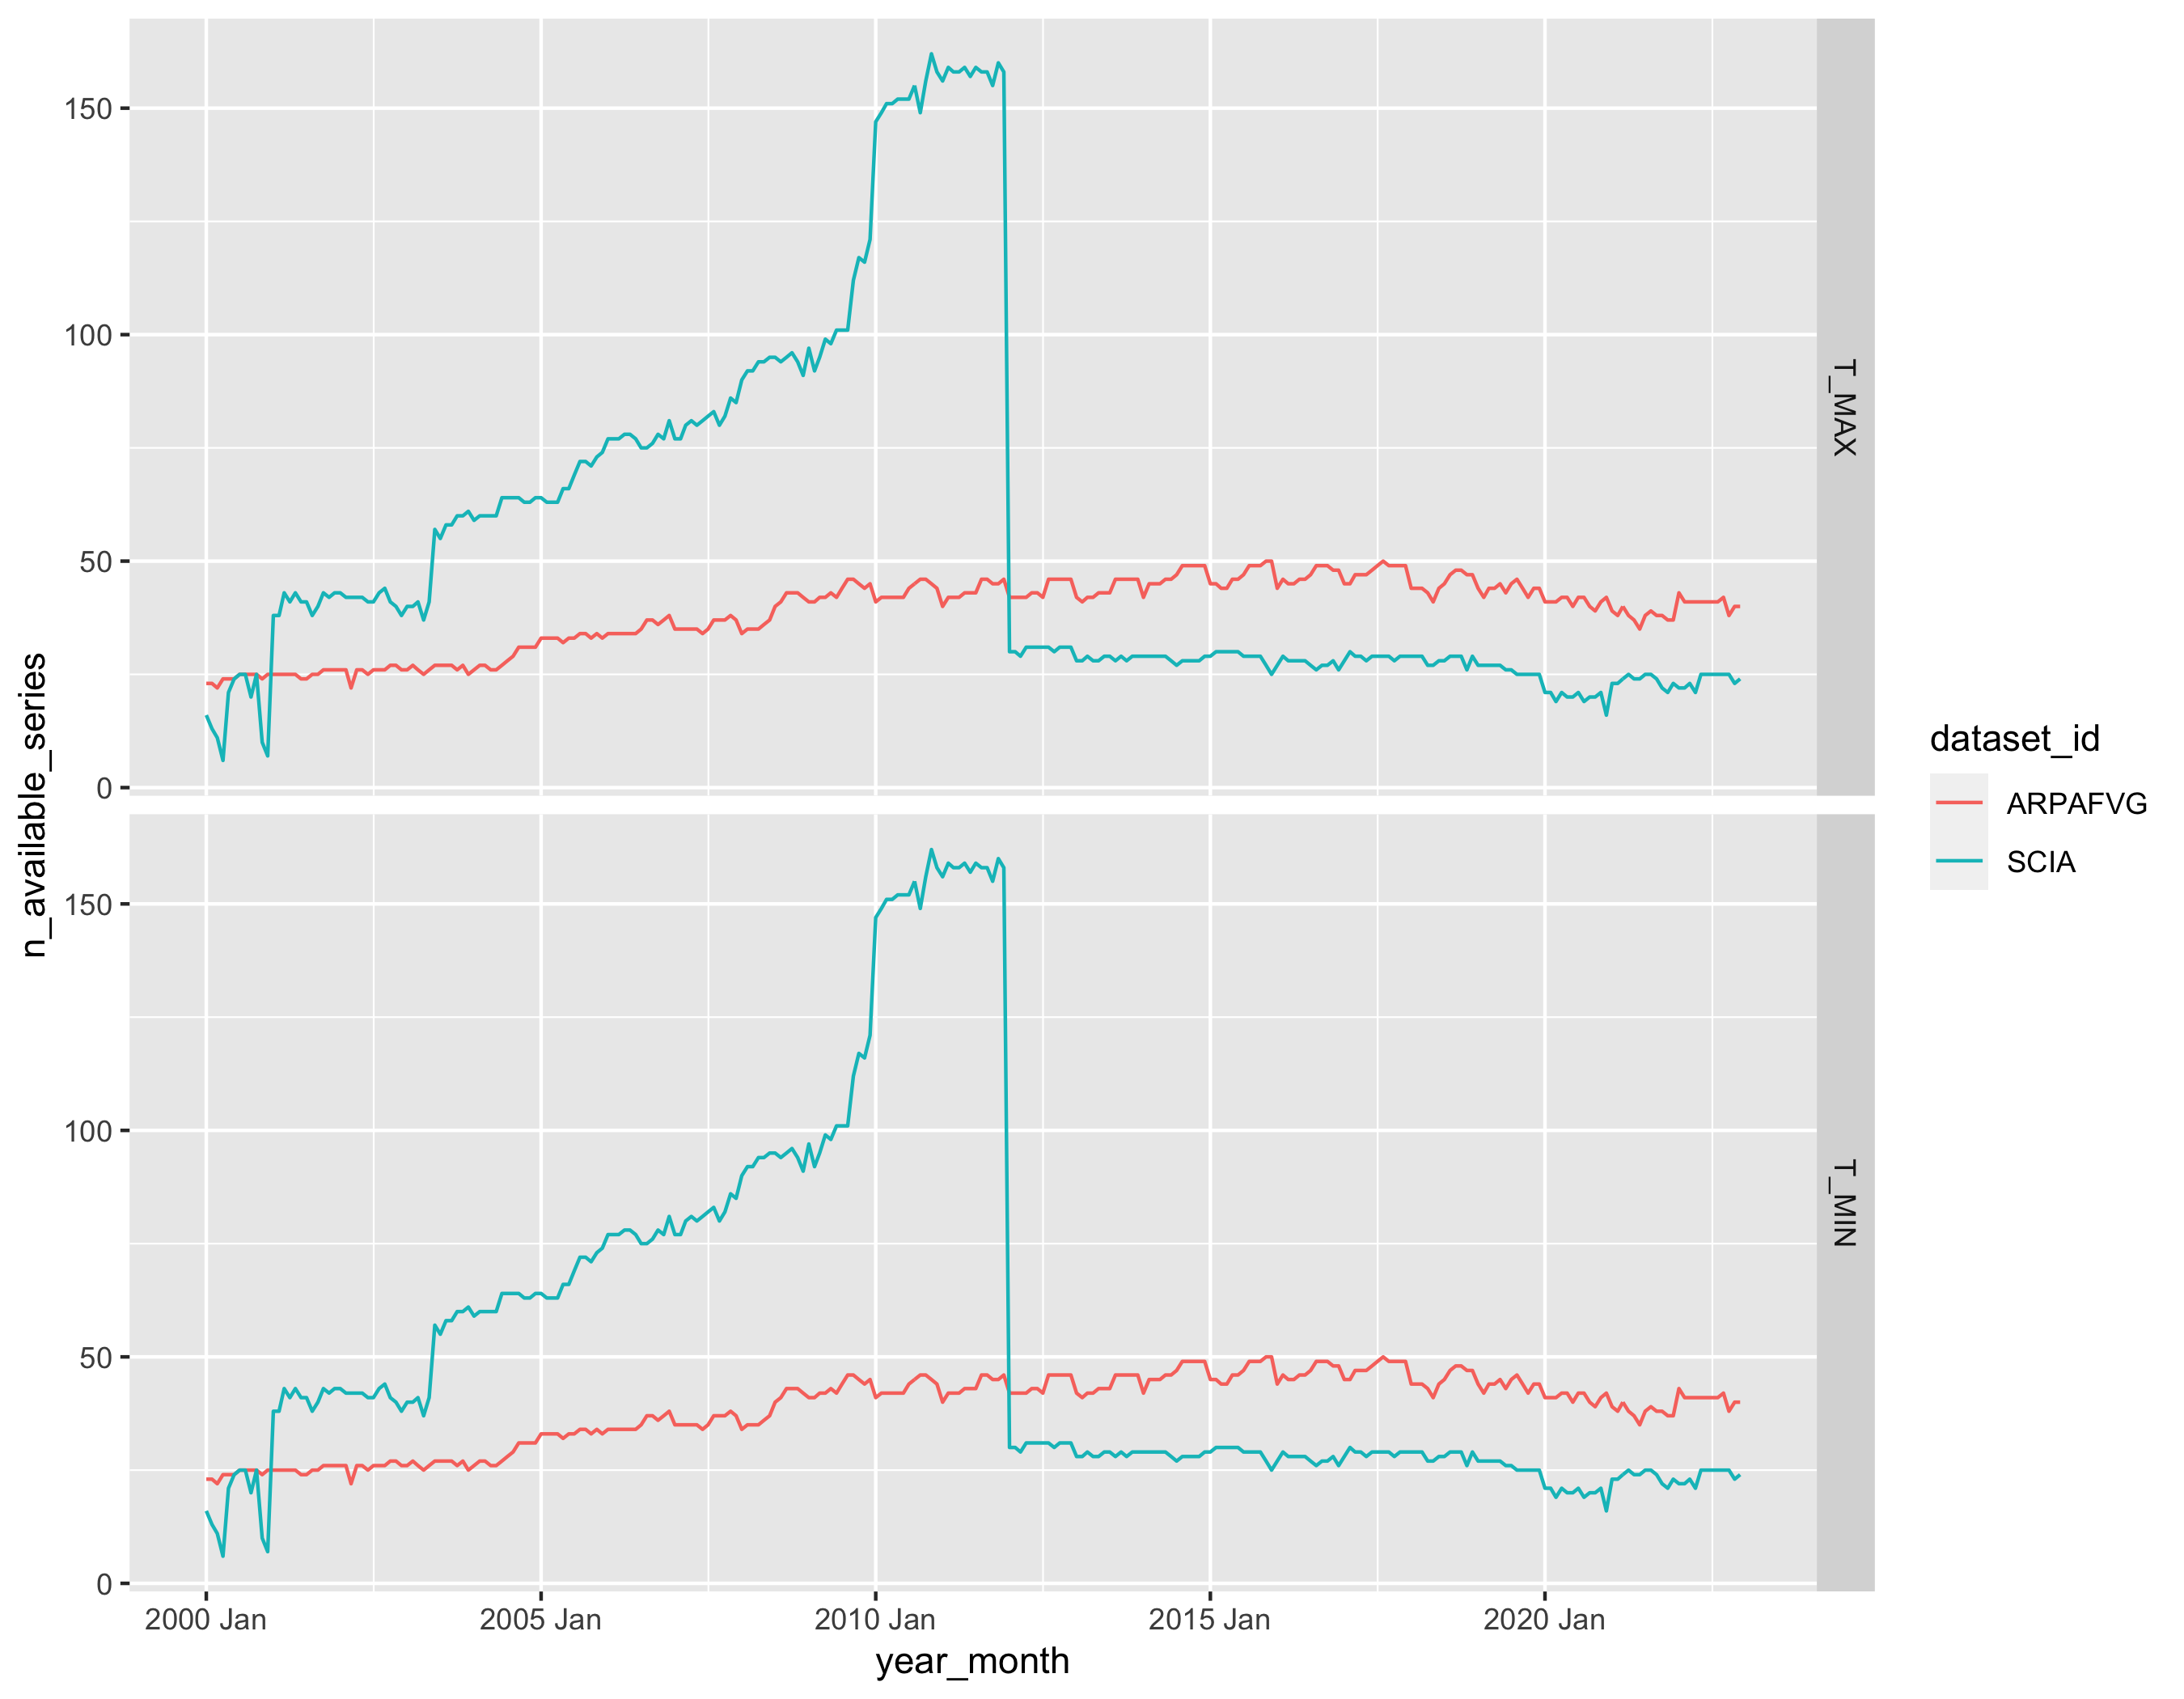

In [13]:
qc_database <- open_checkpoint(dataset_id, "qc1")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(qc_database,
    against = "SCIA",
    region = state_boundaries,
    chkp_id = "qc1",
    start_date = first_date,
    end_date = last_date
)
p


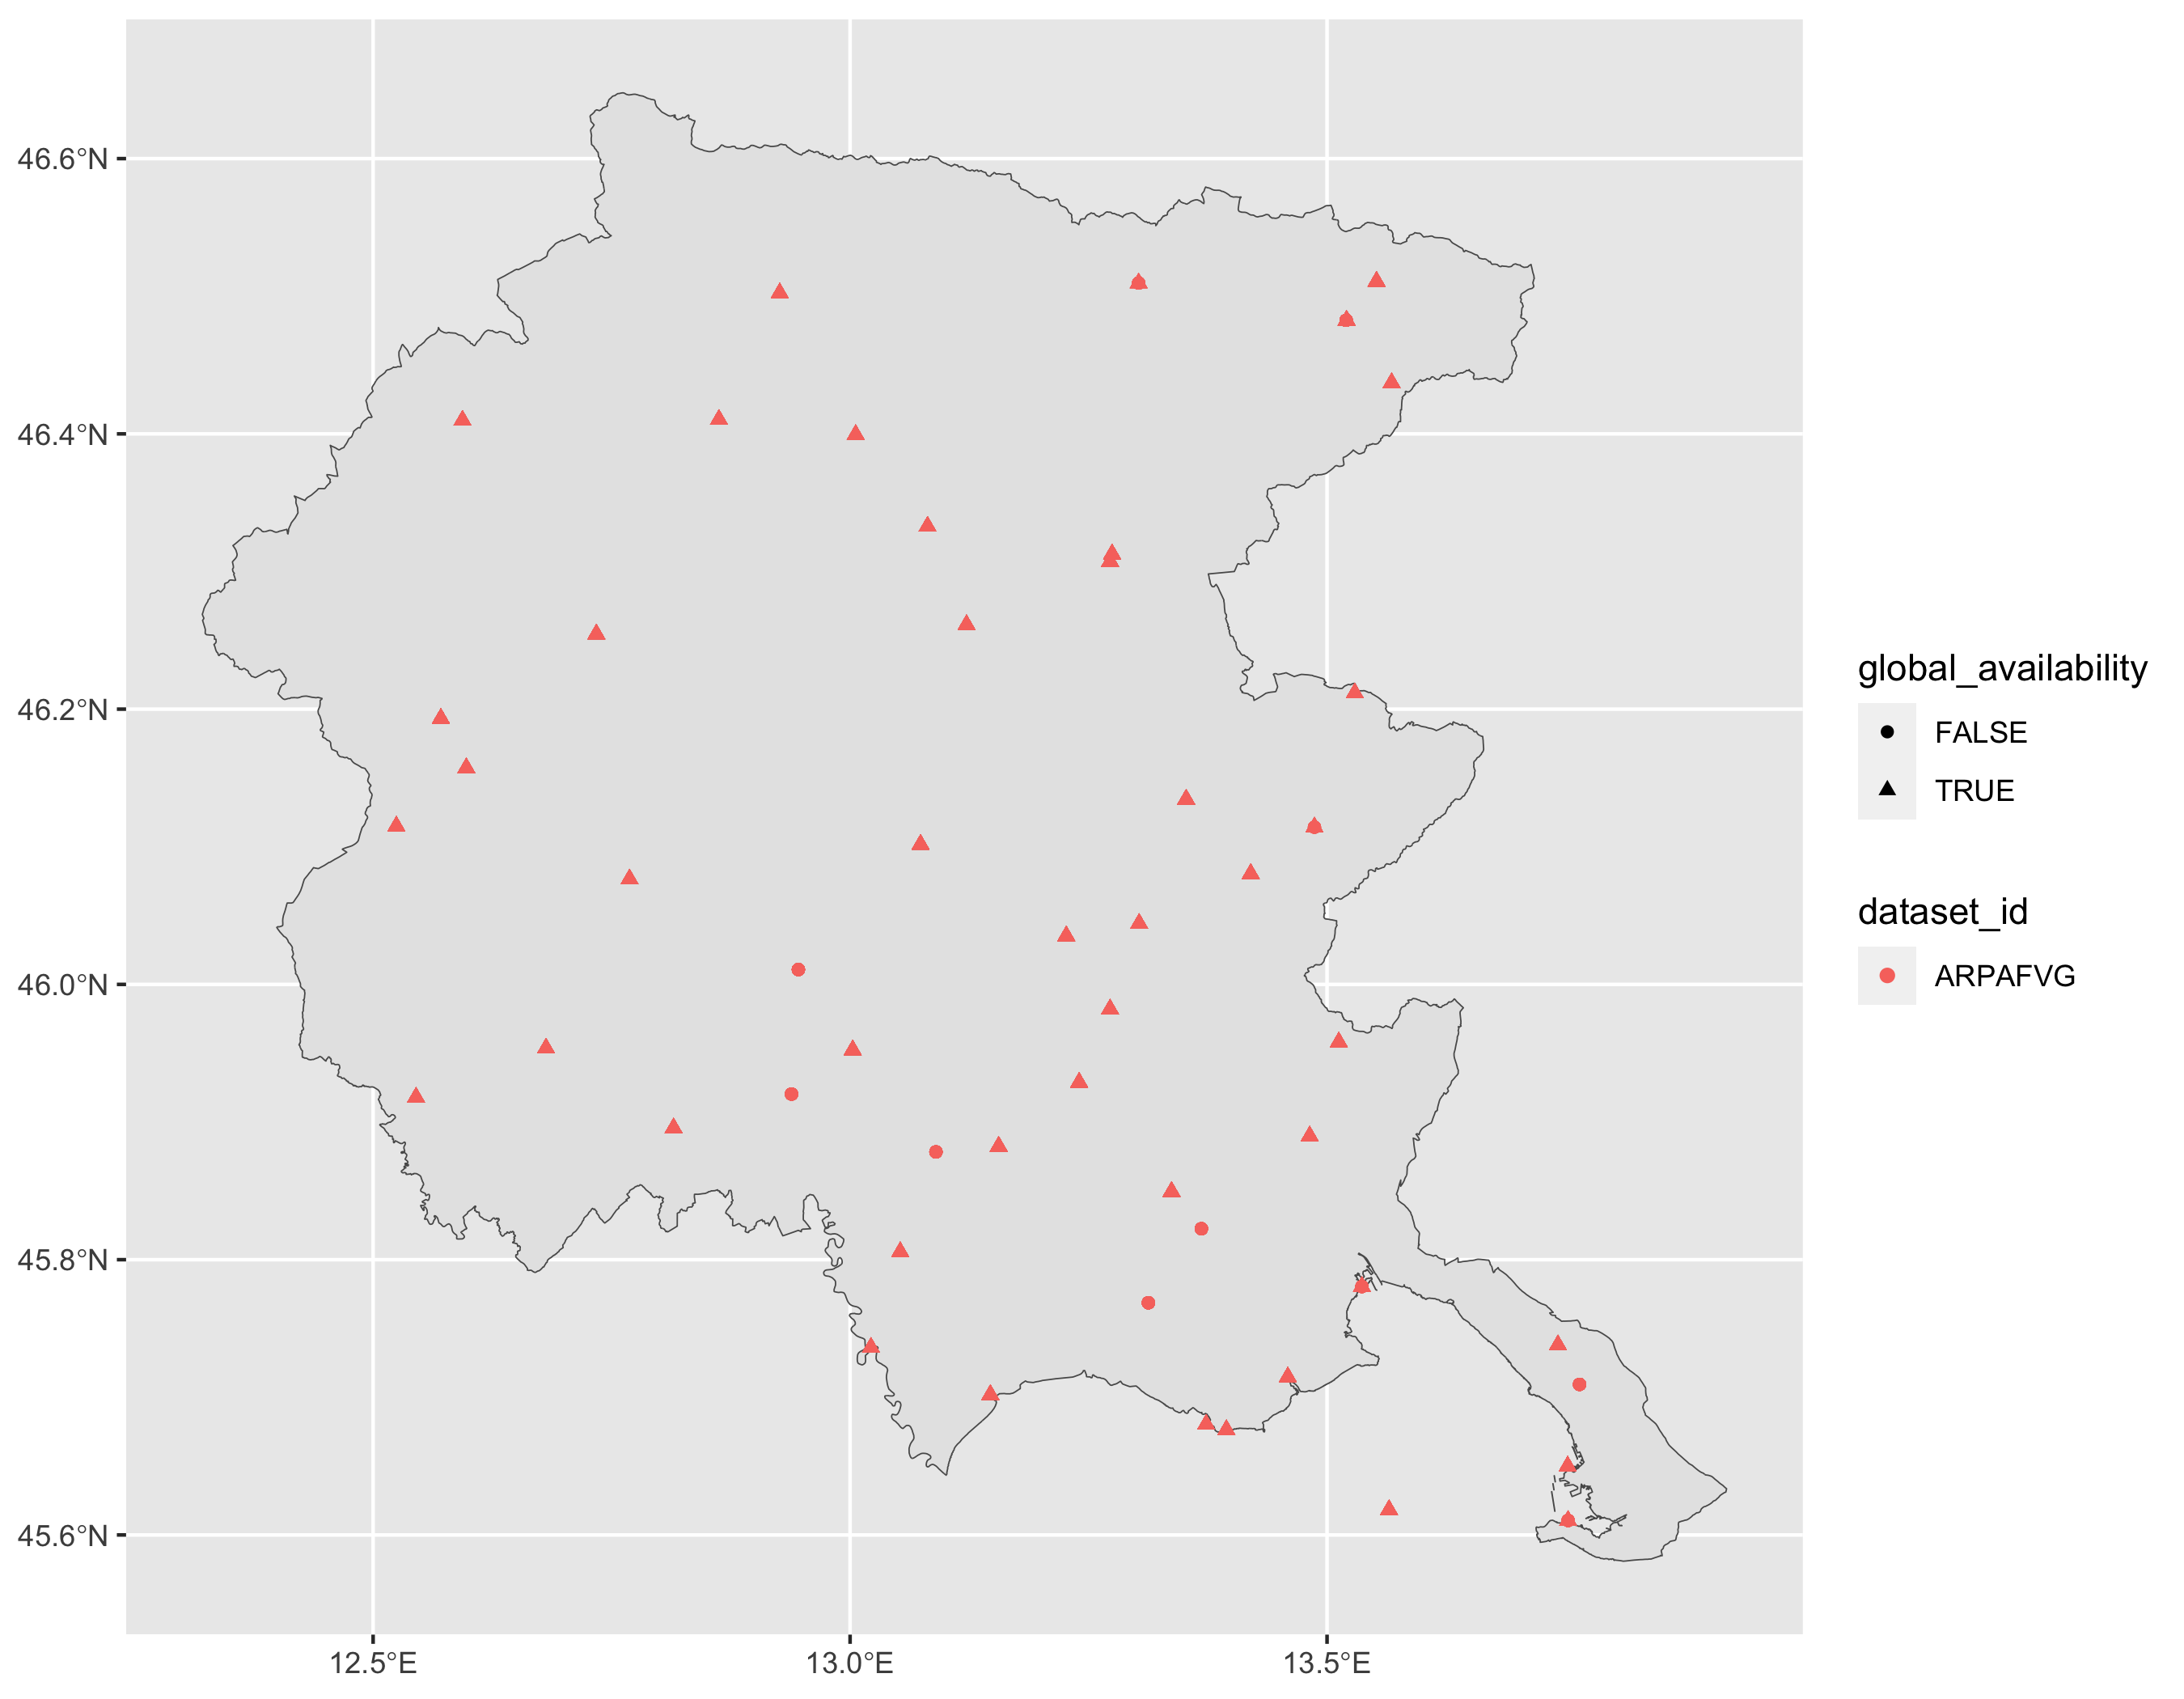

In [14]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail |> filter(dataset_id == !!dataset_id), qc_database$meta, state_boundaries)
p


In [ ]:
rm(qc_database)
rm(ymonthly_avail)
rm(climats)
rm(p)
gc()


## Merging
Gap-filling con altri dataset

### Match stazioni
Partendo dal file di analisi appena scritto preparo dei filtri che categorizzino il match.

Le possibilità sono:
- `tag_same_station`: il match indica una stessa stazione;
- `tag_unusable`: il match è inutilizzabile;
- `tag_pairable`: il match indica che le stazioni sono utilizzabili per fare gap-filling.

Può essere che un match sia sulla stessa stazione ma che sia inutilizzabile; `tag_unusable` e `tag_pairable` invece si dovrebbero escludere vicendevolmente.

In [21]:
# qc_state <- open_checkpoint(dataset_id, "qc1")
qc_dpc <- open_checkpoint("ISAC", "qc1") |> filter_checkpoint_inside(state_boundaries |> st_buffer(dist = units::set_units(5, "km")))
qc_scia <- open_checkpoint("SCIA", "qc1") |> filter_checkpoint_inside(state_boundaries |> st_buffer(dist = units::set_units(5, "km")))
analysis_results <- perform_analysis(
    qc_dpc,
    qc_scia,
    dist_km = 7,
    first_date,
    last_date,
    "FVG",
)

rm(qc_scia)
rm(qc_dpc)
gc()


Data prepared. Launching analysis...

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2053473,109.7,5771617,308.3,NA,5771617,308.3
Vcells,9927520,75.8,302414109,2307.3,16384,409342930,3123.1


In [22]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station, "unusable" = tag_unusable))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)


same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,291
FALSE,TRUE,636
TRUE,FALSE,338
TRUE,TRUE,3


station_id.x,n
<chr>,<int>
04b3a76bdc902bf7ba399b3bc7347fa8,3
05bb6e98d1727c9f7d79731a07349694,4
0a822df8271eb1b7d33b6d4728ac0054,4
110d01fcfa097906bce5aa39f3d6cb15,4
15b822cde80256f377e9426276ed64a2,4
1844630b751d0301235bb41b53cf4dd3,4
23317cfd0e132ae70ce5fb1d2bc55a0b,3
27179f7951ef2bfade6f49534d1a9a9b,4
28235088ddb57affedcab537ef32f458,3


station_id.y,n
<chr>,<int>
10b4bc796cc7370b83e8c8dd6376b961,4
127a645989c3c7aa86181f63a6e49029,4
214b5a6ad7db7913d4a9d36924528764,1
2d9211fbc2a2e37885b3fc98afac3a22,4
318b8eeef0cc7a85137cc02e4b28e00f,4
321736085b07b5c0cf38d187391b34ec,1
81f1521ec007a741b3442fa815ebbff3,3
82591ecf4a8fba7e83db324b9142082e,4
82eb05f8e61f9c1e0e7b4f9a5c6d14f6,1


In [23]:
combination_results <- build_combined_database(analysis_results, checks = TRUE, test_bounds = 5)
checkpoint_database(combination_results$database, dataset_id, "merged_isac_scia")
save_match_list(combination_results$match_list, dataset_id, "merged_isac_scia")


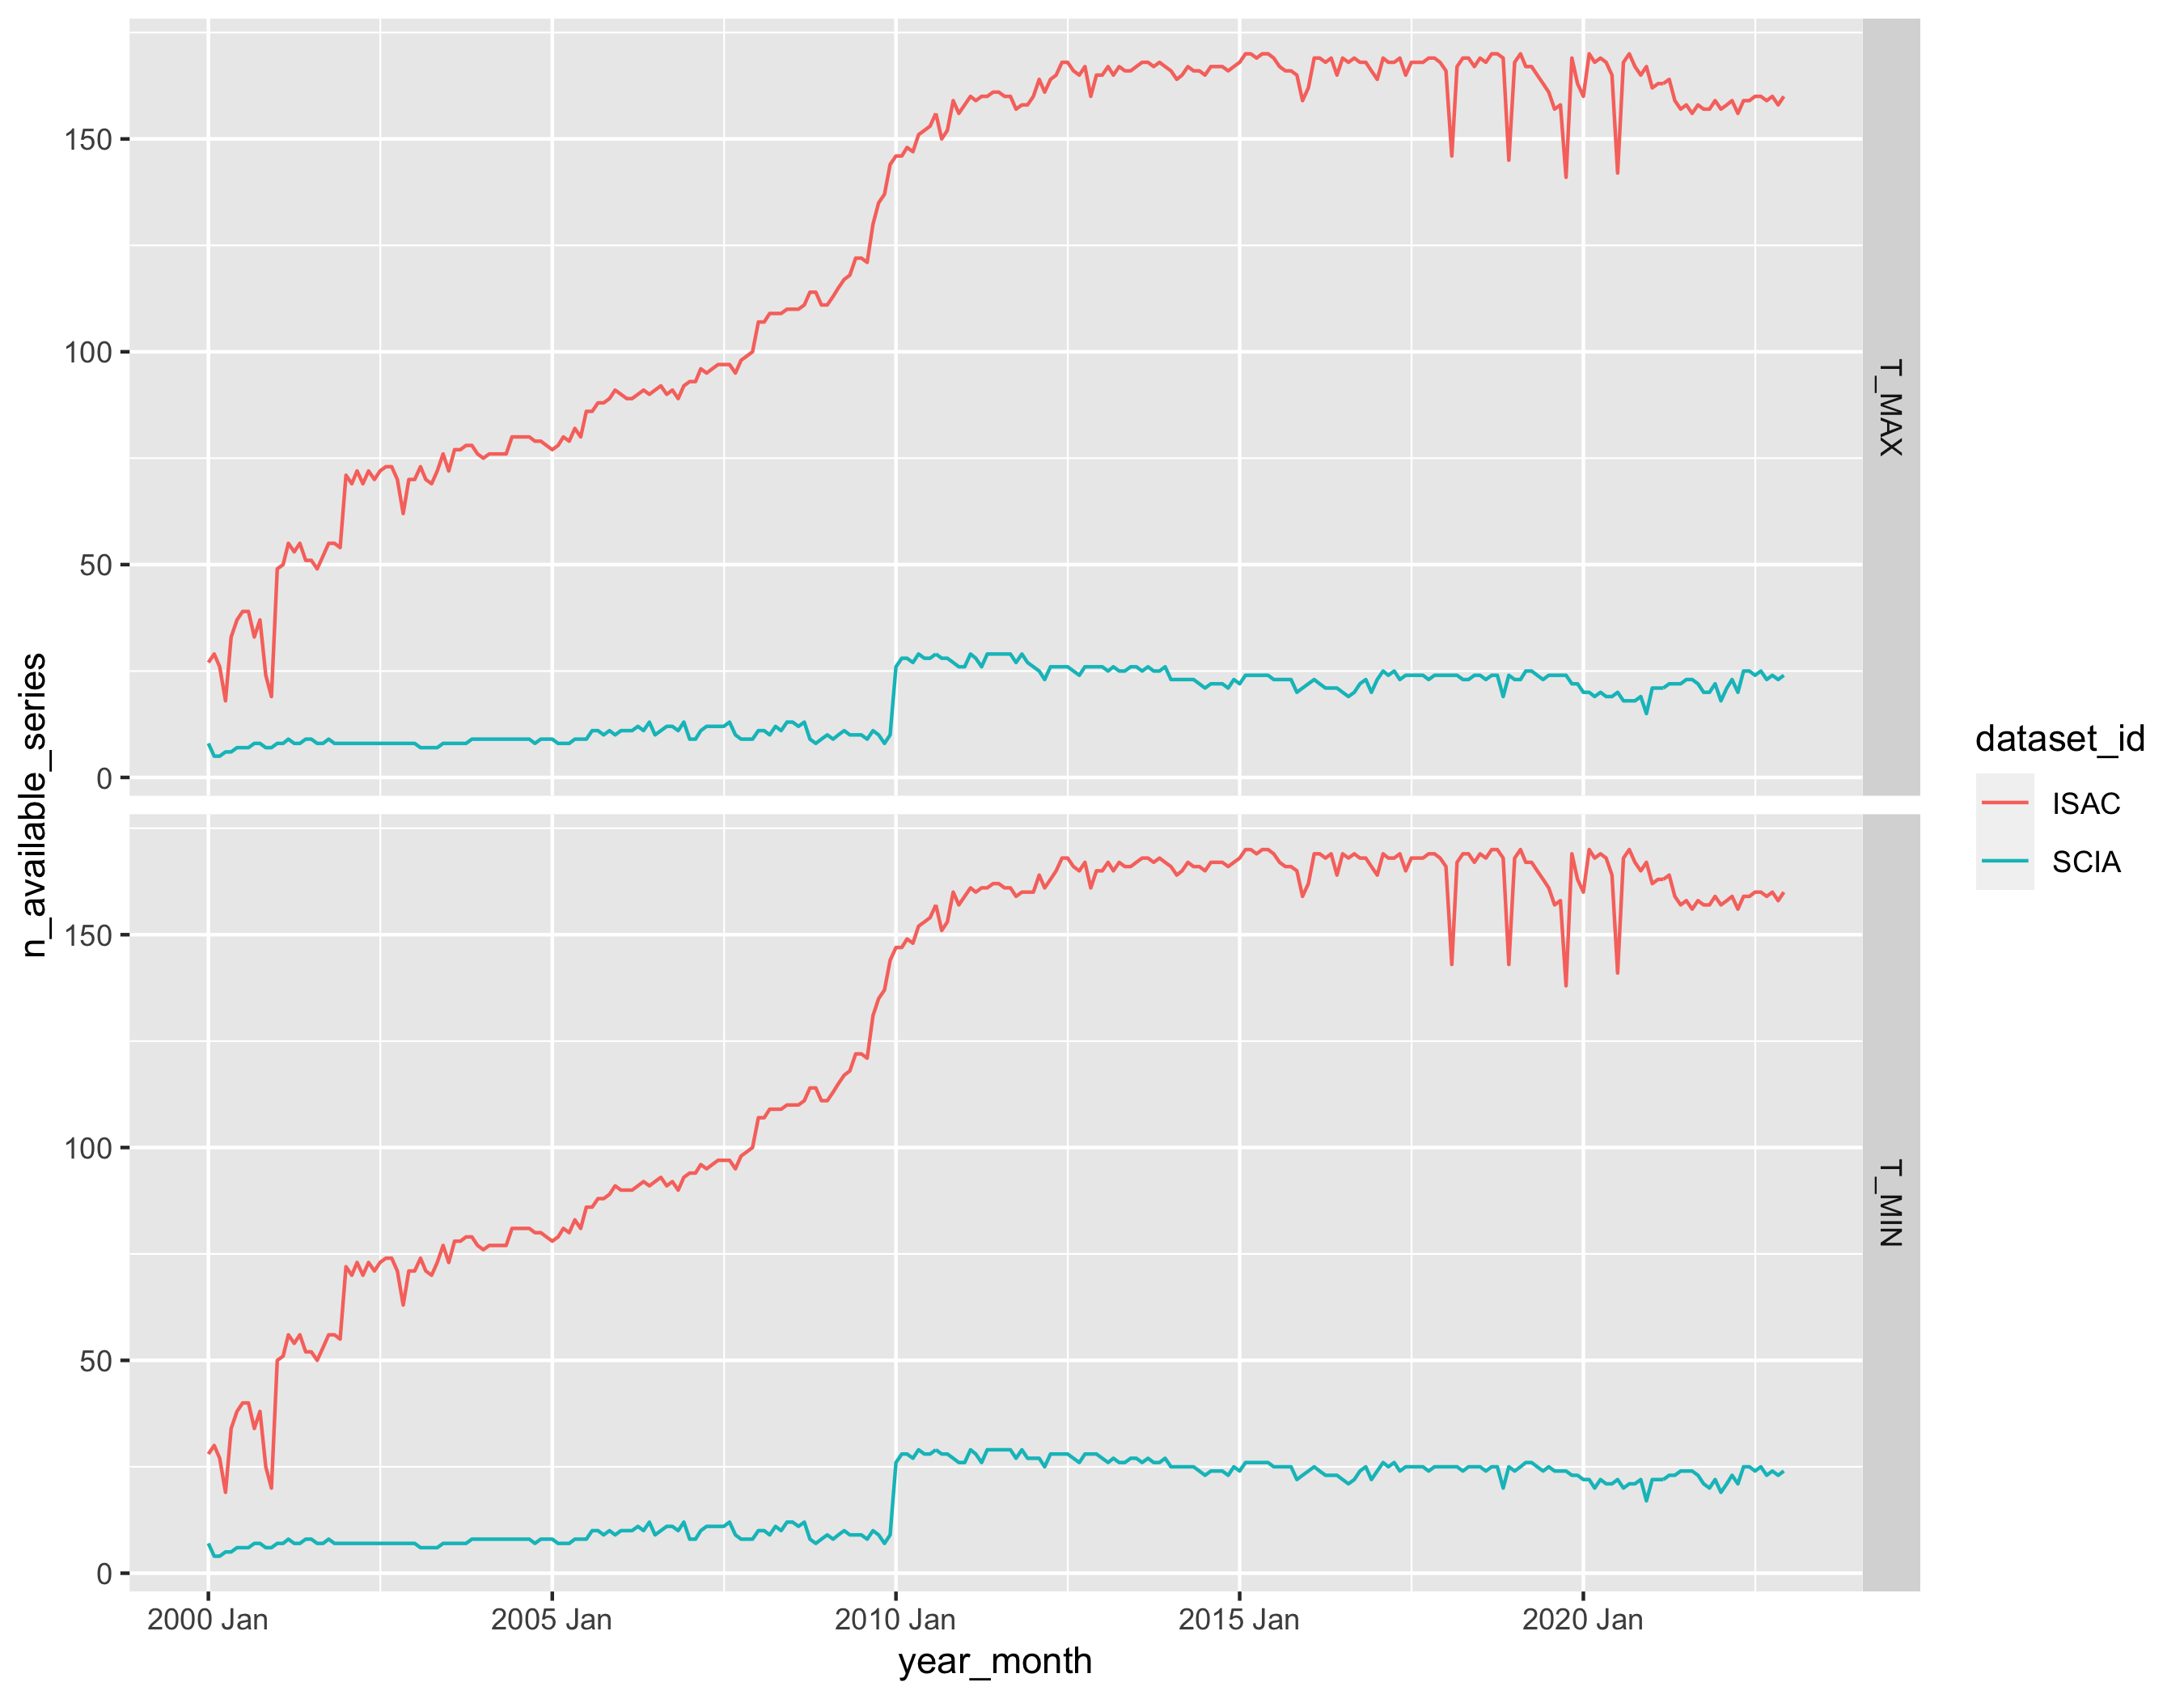

In [24]:
combined_database <- open_checkpoint(dataset_id, "merged_isac_scia")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p


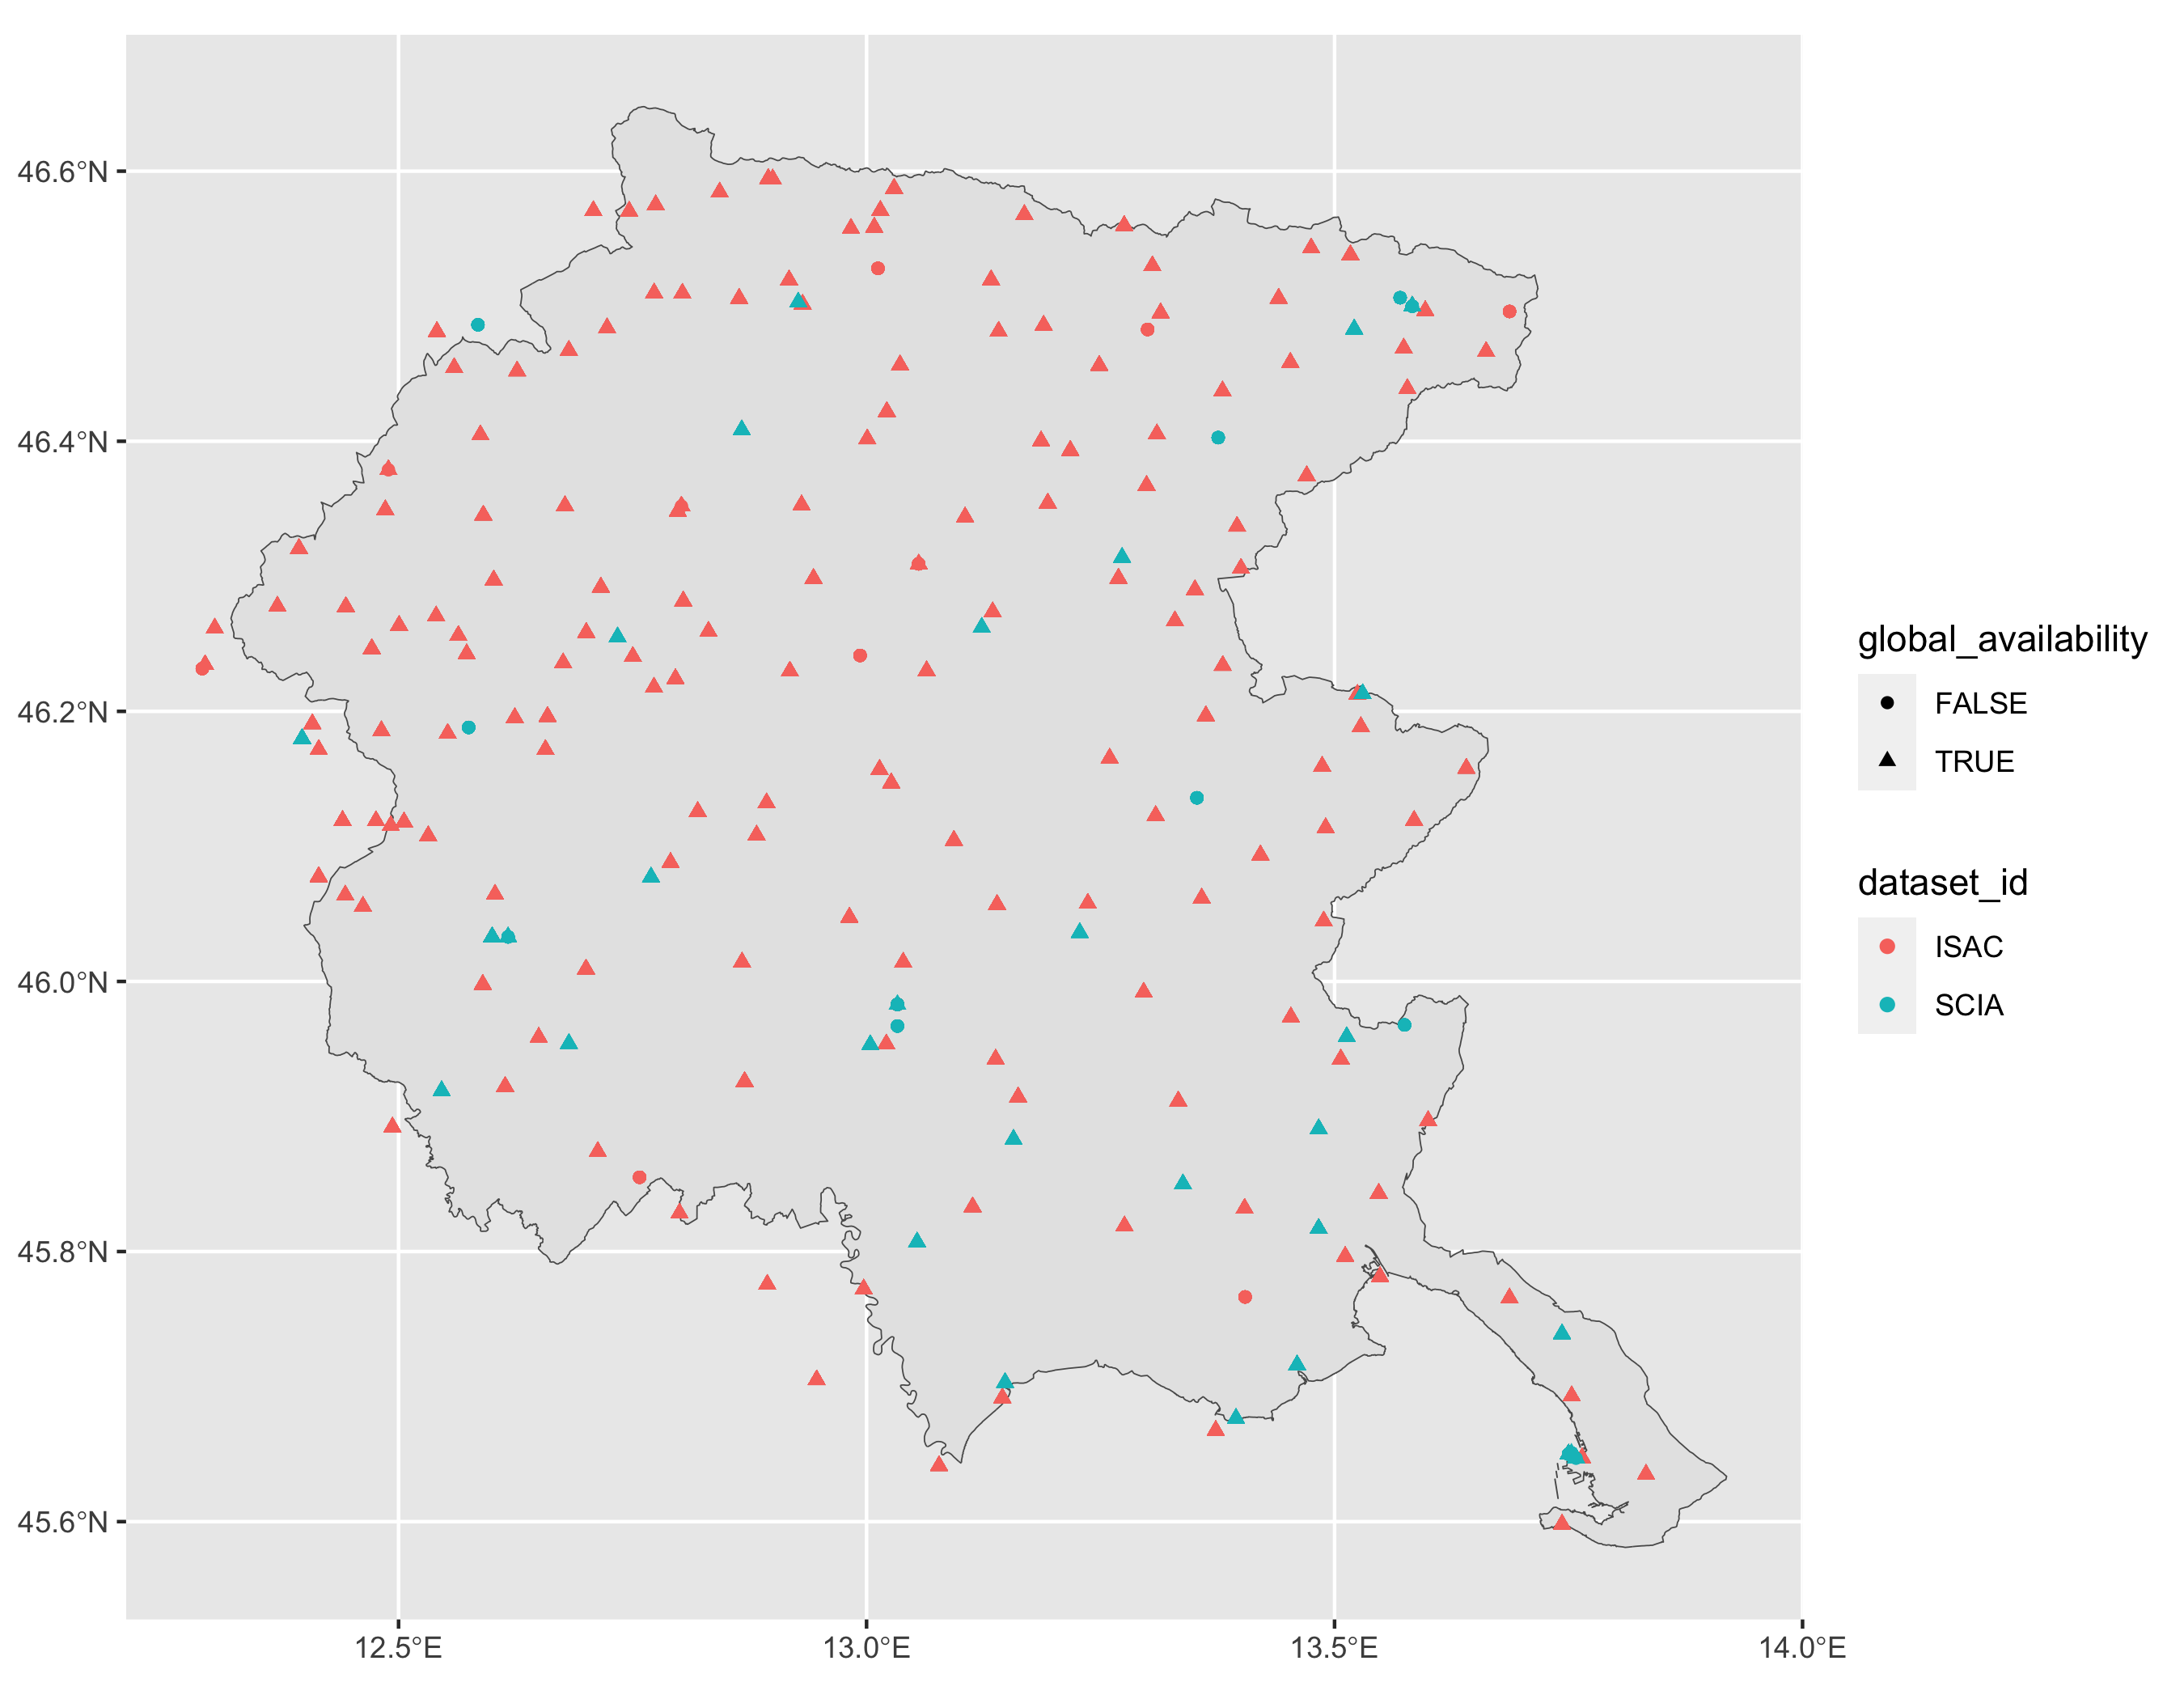

In [25]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p


In [ ]:
# Launch in an R terminal to see an interactive map
source("src/pairing/displaying.R")
source("notebooks/integrazioni_regionali/procedure/checkpoint.R")
combined_database <- open_checkpoint(dataset_id, "merged_isac_scia")
launch_leaflet(combined_database)


In [26]:
rm(ymonthly_avail)
rm(climats)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2330667,124.5,5771617,308.3,NA,5771617,308.3
Vcells,13017401,99.4,194211120,1481.8,16384,409342930,3123.1


In [37]:
qc_state <- open_checkpoint(dataset_id, "qc1")
qc_isacscia <- open_checkpoint(dataset_id, "merged_isac_scia") |> filter_checkpoint_inside(state_boundaries)
analysis_results <- perform_analysis(
    qc_state,
    qc_isacscia,
    dist_km = 10,
    first_date,
    last_date,
    "FVG",
)

Data prepared. Launching analysis...

In [44]:
analysis_results <- tag_analysis(analysis_results, list("same_station" = tag_same_station_arpa_merged, "unusable" = tag_unusable_arpa_merged))
analysis_results$analysis |>
        group_by(same_station, unusable) |>
        tally()
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.x) |>
        tally() |>
        filter(n != 2L)
filter(analysis_results$analysis, same_station) |>
        group_by(station_id.y) |>
        tally() |>
        filter(n != 2L)

same_station,unusable,n
<lgl>,<lgl>,<int>
FALSE,FALSE,222
FALSE,TRUE,300
TRUE,FALSE,77
TRUE,TRUE,14
NA,FALSE,8
NA,TRUE,10


station_id.x,n
<chr>,<int>
0aa8f79b1259b335bf36901e4143e8d7,4
0d25ae1f40385b74c2057cfadc33f697,3
24aaa82a829e441ae75a569741b77871,3
5a18f715cdb2ef7b67f5147823763c75,1
61f2cf2542a781489e9ed58b3dd59a92,3
6cafaed960b7a8406ddf074f6a0899ef,1
7e32ea98a0e9907786ea4fb9ecaac8f4,1
bf016e2513edfe42550c5804bb72d2da,4
c0afec245978ef84bce8e4e8c88b6861,5


station_id.y,n
<chr>,<int>
01d78118852dfc71cb9fa0f116d057a7,1
214b5a6ad7db7913d4a9d36924528764,1
321736085b07b5c0cf38d187391b34ec,1
3fd6f6c528487987d5a9bc019f8eff8c,1
4c201528eced7ad0cfe5297bbd31d4f7,4
502df92e292402052abf4bfeaa4ca505,1
a45c5ae8fa156a88ae1b55ef33c9bb08,4
b35c6ef3bb1a79ff1cba8b5c427f1e8a,1
e834849fa0a4912b854a1fe425acf412,1


In [45]:
combination_results <- build_combined_database(analysis_results, checks = TRUE, test_bounds = 5)
checkpoint_database(combination_results$database, dataset_id, "merged")
save_match_list(combination_results$match_list, dataset_id, "merged")


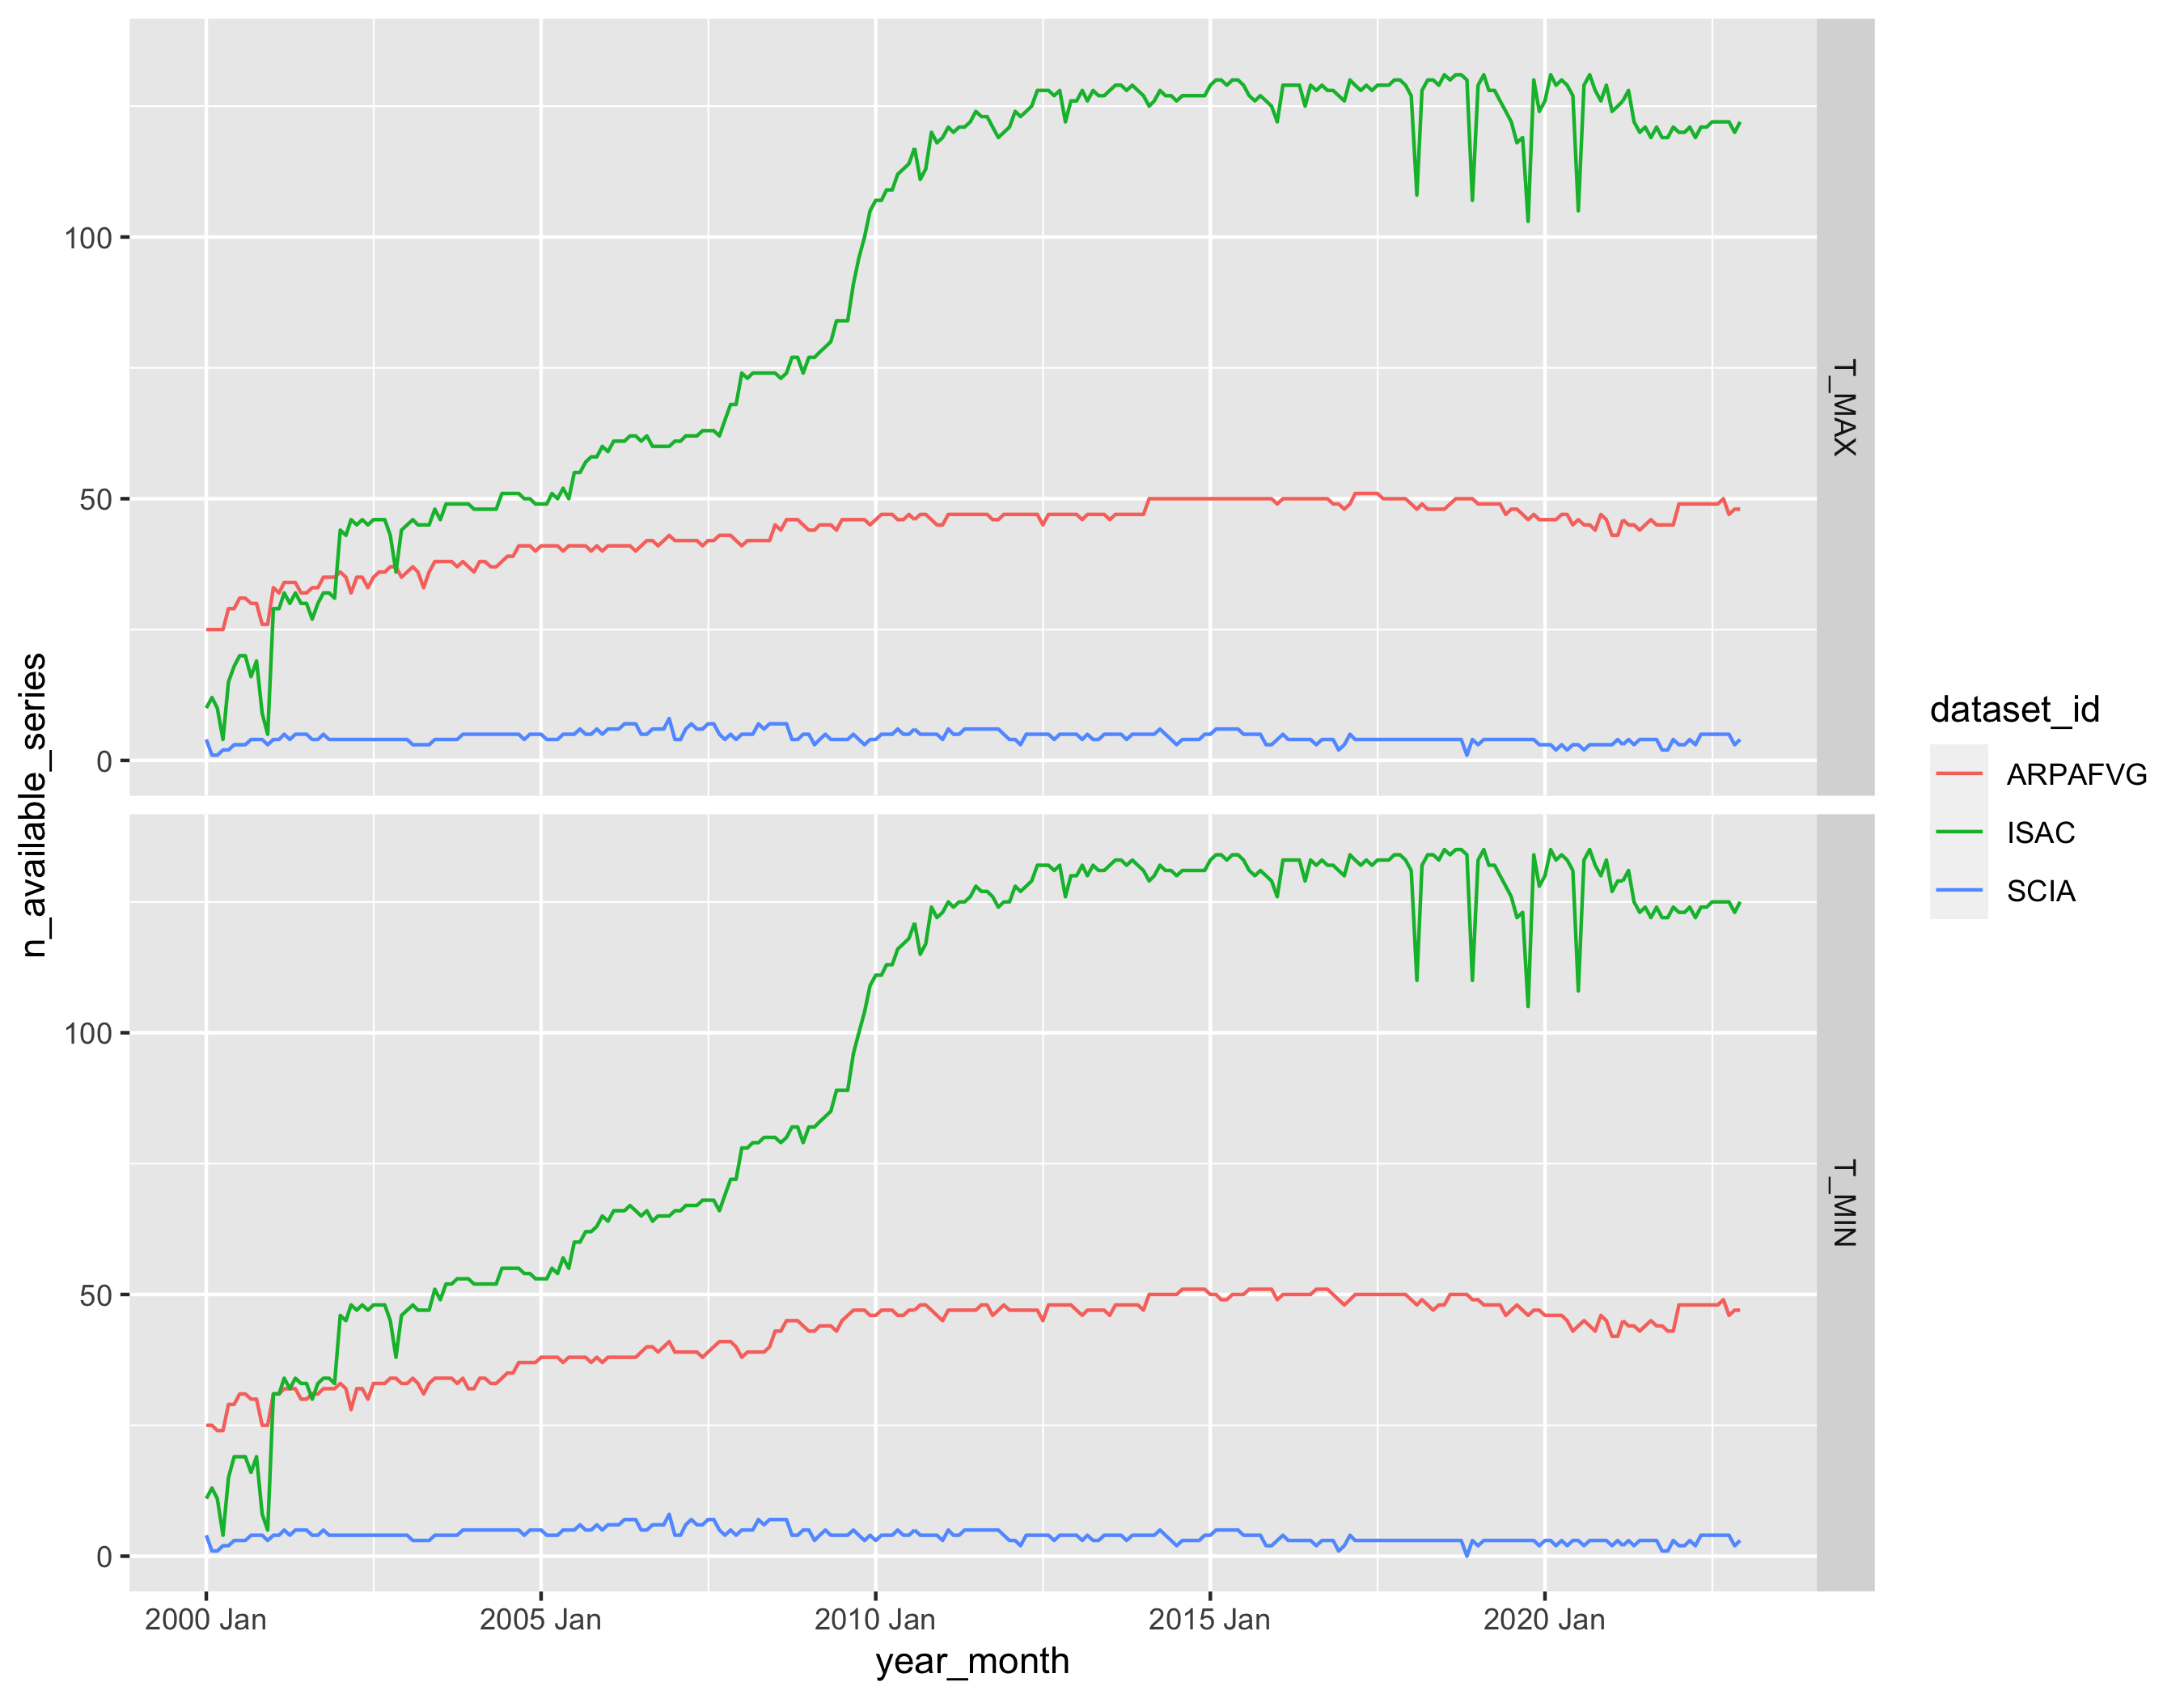

In [46]:
combined_database <- open_checkpoint(dataset_id, "merged")
c(p, ymonthly_avail) %<-% ymonthly_availabilities(combined_database,
    start_date = first_date,
    end_date = last_date
)
p

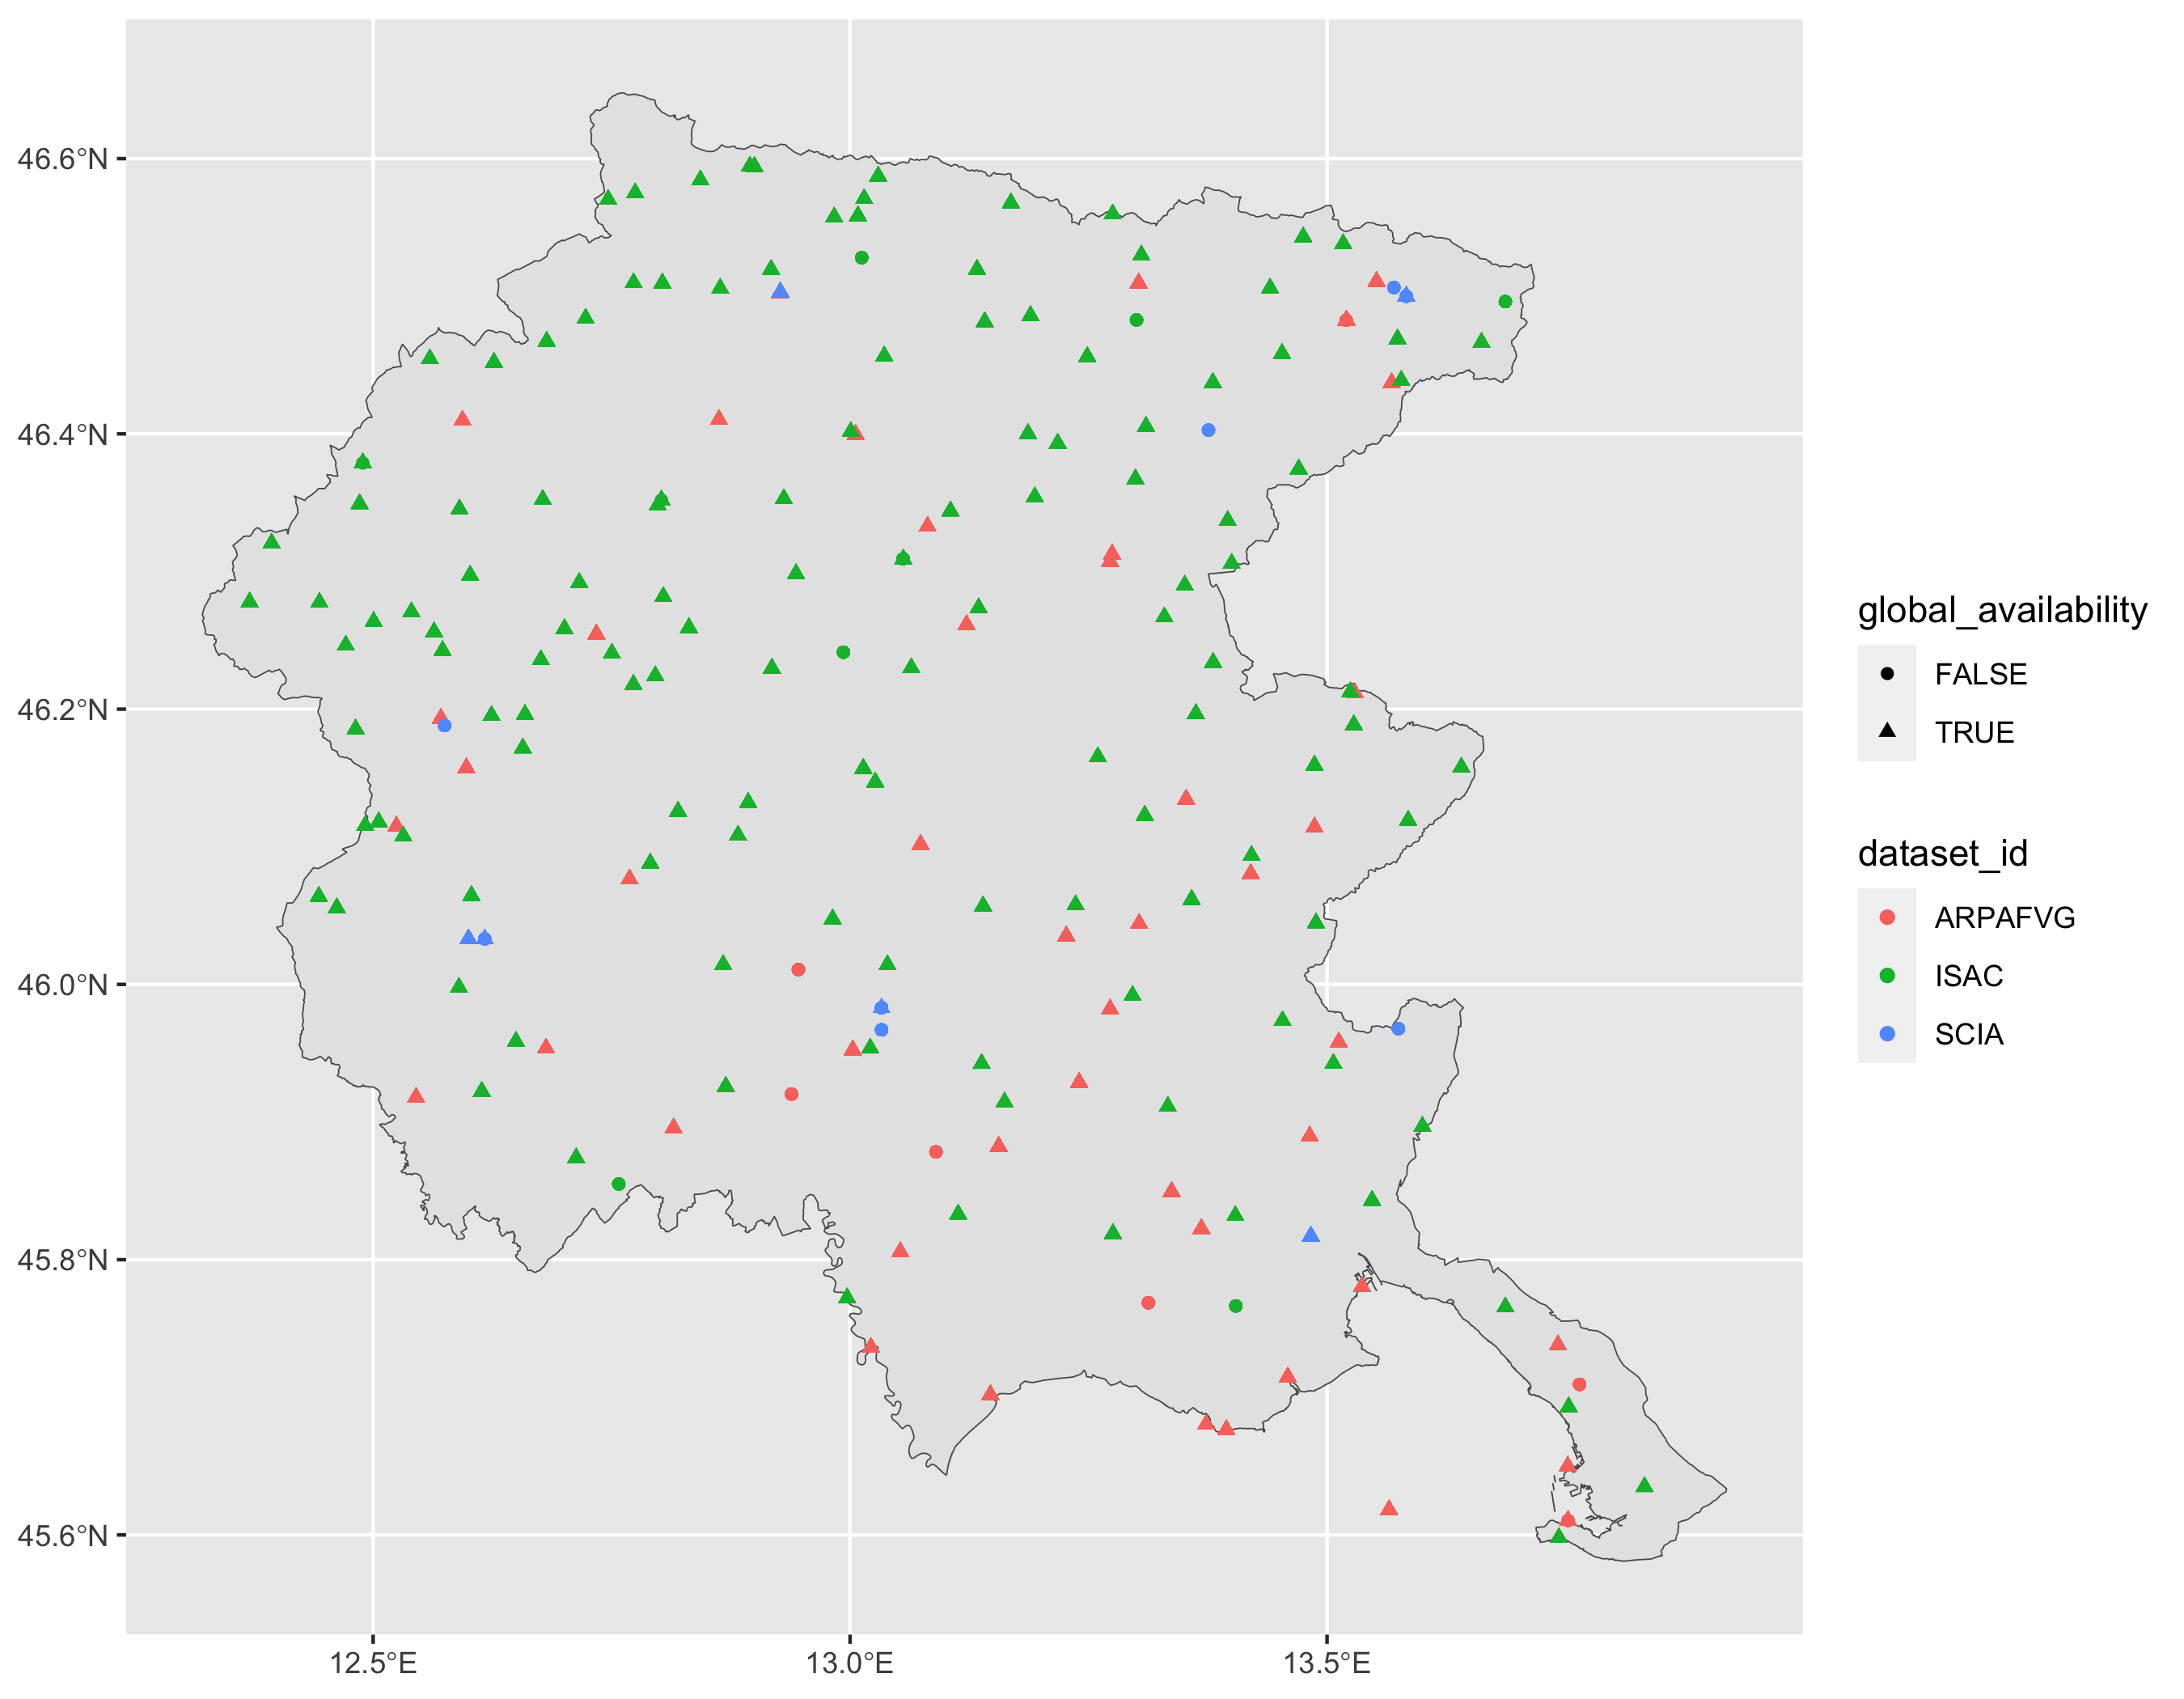

In [47]:
c(p, climats) %<-% spatial_availabilities(ymonthly_avail, combined_database$meta, state_boundaries)
p
